# Training Log Analysis
Questo notebook carica `training_log.csv` prodotto da `train.py` e mostra le curve di loss per train/val/test. Modifica il percorso in base alla run che vuoi ispezionare.

In [1]:
1+1

2

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

out_path = Path('../outputs/runs/exp_resnet_problabels_9')

#LOG_PATH = Path('../outputs/runs/exp7_temporalT3/training_log.csv')
LOG_PATH = out_path / Path('training_log.csv')
log_df = pd.read_csv(LOG_PATH)
#display(log_df)


# 

## Loss

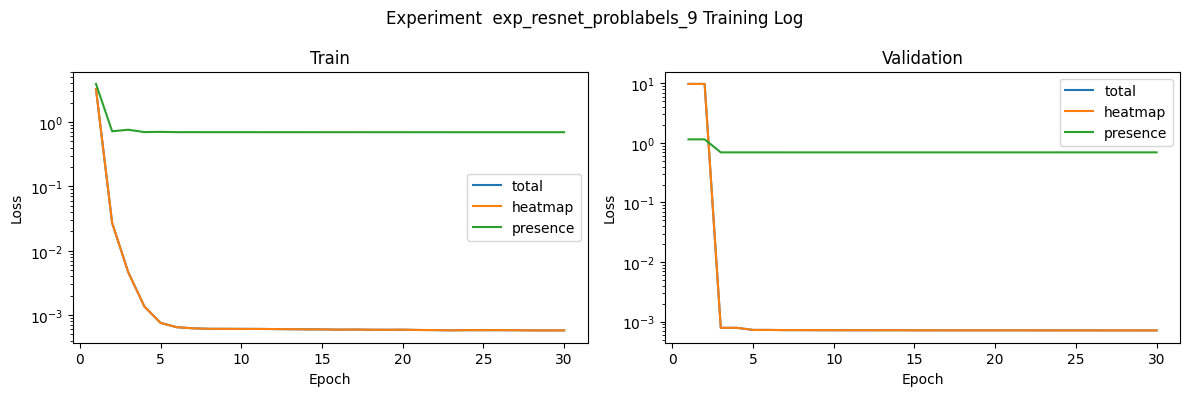

In [8]:

splits = {
    'Train': ('train_loss', 'train_heatmap_loss', 'train_presence_loss'),
    'Validation': ('val_loss', 'val_heatmap_loss', 'val_presence_loss'),
    #'Test': ('test_loss', 'test_heatmap_loss', 'test_presence_loss', 'test_presence_combined_loss')
}

log_df = pd.read_csv(LOG_PATH)

fig, axes = plt.subplots(1, len(splits), figsize=(6 * len(splits), 4), sharex=True)
if not isinstance(axes, (list, tuple, np.ndarray)):
    axes = [axes]

for ax, (title, cols) in zip(axes, splits.items()):
    epochs = log_df['epoch']
    plotted = False
    labels = []
    for metric in cols:
        if 'heatmap' in metric:
            labels.append('heatmap')
        elif 'presence_combined' in metric:
            labels.append('presence_combined')
        elif 'presence' in metric:
            labels.append('presence')
        else:
            labels.append('total')
    for metric, label in zip(cols, labels):
        series = log_df[metric].bfill()
        if series.notna().any():
            ax.plot(epochs[:], series[:], label=label)
            plotted = True
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if plotted:
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', va='center', fontsize=12)
    ax.set_yscale('log')

plt.suptitle('Experiment  {} Training Log'.format(LOG_PATH.parent.name))
plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'training_log_plot.png')


## Eval metrics
Queste celle consumano `outputs/preds/metrics.json` e le curve PR/ROC generate da `infer.py` per dare un colpo d'occhio alle prestazioni sul manifest di valutazione.

In [33]:

METRICS_PATH = out_path / Path('metrics.json')
if not METRICS_PATH.exists():
    raise FileNotFoundError(f'Metrics file not found: {METRICS_PATH}')

with open(METRICS_PATH) as f:
    eval_metrics = json.load(f)

def summarize(name, metrics_dict):
    if not metrics_dict:
        return None
    return {
        'variant': name,
        'AUPRC': metrics_dict.get('auprc'),
        'ROC_AUC': metrics_dict.get('roc_auc'),
        'Precision@τ': metrics_dict.get('precision_at_tau'),
        'Recall@τ': metrics_dict.get('recall_at_tau'),
        'F1@τ': metrics_dict.get('f1_at_tau'),
        'τ usata': metrics_dict.get('threshold')
    }

presence_comb = eval_metrics.get('presence_metrics_combined', {})
presence_logit = eval_metrics.get('presence_metrics_logit', {})
rows = [r for r in (summarize('combined', presence_comb), summarize('logit', presence_logit)) if r]
presence_summary = pd.DataFrame(rows)
display(presence_summary)

for name, metrics_dict in [('combined', presence_comb), ('logit', presence_logit)]:
    if not metrics_dict:
        continue
    conf = metrics_dict.get('confusion_matrix', {})
    conf_df = pd.DataFrame(
        [[conf.get('tp', 0), conf.get('fp', 0)],
         [conf.get('fn', 0), conf.get('tn', 0)]],
        index=['GT=1', 'GT=0'],
        columns=['Pred=1', 'Pred=0']
    )
    display(conf_df)


,variant,AUPRC,ROC_AUC,Precision@τ,Recall@τ,F1@τ,τ usata
0,combined,0.724724,0.5,0.449448,1.0,0.620164,0.5
1,logit,0.724724,0.5,0.449448,1.0,0.620164,0.5


,Pred=1,Pred=0
GT=1,2116,2592
GT=0,0,0


,Pred=1,Pred=0
GT=1,2116,2592
GT=0,0,0


### Curve PR e ROC
Se `--sweep-curves DIR` era attivo durante l'inferenza, le curve vengono salvate in CSV e visualizzate qui.

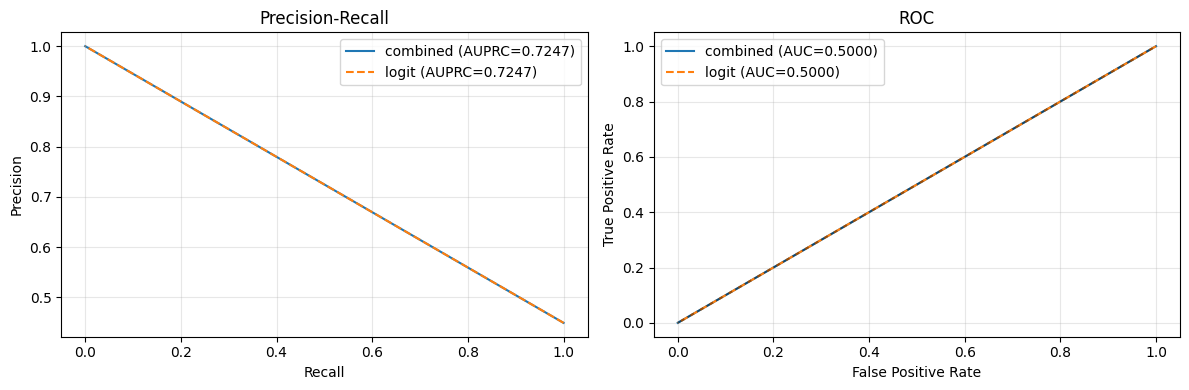

In [34]:

CURVES_DIR = out_path /  Path('curves')
pr_comb_path = CURVES_DIR / 'pr_curve_combined.csv'
roc_comb_path = CURVES_DIR / 'roc_curve_combined.csv'
pr_logit_path = CURVES_DIR / 'pr_curve_logit.csv'
roc_logit_path = CURVES_DIR / 'roc_curve_logit.csv'

if not (pr_comb_path.exists() and roc_comb_path.exists()):
    raise FileNotFoundError('Curve PR/ROC non trovate: assicurati di aver passato --sweep-curves e che i file *_combined.csv esistano.')

pr_comb_df = pd.read_csv(pr_comb_path)
roc_comb_df = pd.read_csv(roc_comb_path)
pr_logit_df = pd.read_csv(pr_logit_path) if pr_logit_path.exists() else None
roc_logit_df = pd.read_csv(roc_logit_path) if roc_logit_path.exists() else None

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# PR
if pr_comb_df is not None:
    ap_comb = pr_comb_df['pr_auc'].dropna().iloc[0] if 'pr_auc' in pr_comb_df else None
    axes[0].plot(pr_comb_df['recall'], pr_comb_df['precision'], label=f'combined (AUPRC={ap_comb:.4f})' if ap_comb is not None else 'combined')
if pr_logit_df is not None:
    ap_logit = pr_logit_df['pr_auc'].dropna().iloc[0] if 'pr_auc' in pr_logit_df else None
    axes[0].plot(pr_logit_df['recall'], pr_logit_df['precision'], label=f'logit (AUPRC={ap_logit:.4f})' if ap_logit is not None else 'logit', linestyle='--')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# ROC
if roc_comb_df is not None:
    auc_comb = roc_comb_df['roc_auc'].dropna().iloc[0] if 'roc_auc' in roc_comb_df else None
    axes[1].plot(roc_comb_df['fpr'], roc_comb_df['tpr'], label=f'combined (AUC={auc_comb:.4f})' if auc_comb is not None else 'combined')
if roc_logit_df is not None:
    auc_logit = roc_logit_df['roc_auc'].dropna().iloc[0] if 'roc_auc' in roc_logit_df else None
    axes[1].plot(roc_logit_df['fpr'], roc_logit_df['tpr'], label=f'logit (AUC={auc_logit:.4f})' if auc_logit is not None else 'logit', linestyle='--')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(LOG_PATH.parent / 'precision-recall-ROC.png')
plt.show()
